In [1]:
import random
import numpy as np
import pandas as pd

# SIR model equations with N=1 (population is normalized)
def sir_equations(y, beta, gamma, mu):
    S, I, R = y
    N = 1  # Total population is set to 1
    dS_dt = mu * (N - S) - (beta * S * I / N)  # Susceptible dynamics
    dI_dt = beta * S * I / N - (mu + gamma) * I  # Infectious dynamics
    dR_dt = gamma * I - mu * R  # Recovered dynamics
    return [dS_dt, dI_dt, dR_dt]

# Time grid
start_time = 0
end_time = 50
time_step = 0.2
t = np.arange(start_time, end_time, time_step)

# Euler method for solving the SIR equations
def eulermethod_sir(sir_equations, initial_conditions, t, params):
    x = initial_conditions
    xs = [x]
    for idx in range(t.shape[0]-1):
        dt = t[idx+1] - t[idx]
        force = sir_equations(x, *params)
        x = [s + dt * f for s, f in zip(x, force)]
        xs.append(x)
    xs = np.array(xs)
    return xs[:,0], xs[:,1], xs[:,2]

# Generate and save the SIR data, splitting into training and testing datasets
def generate_and_save_sir_data(t, num_simulations, split_ratio=0.5, training_file='sir_simulation_data_training', testing_file='sir_simulation_data_testing', train_init_file='sir_initial_conditions_training.csv', test_init_file='sir_initial_conditions_testing.csv'):
    # Mean parameters
    beta_mean, gamma_mean, mu_mean = 0.9, 0.2, 0.3
    
    data = np.empty((num_simulations, t.shape[0], 3))  # 3 represents [S, I, R]
    initial_conditions_list = []

    # Generate synthetic datasets
    for i in range(num_simulations):
        # Use fixed mean parameters
        beta, gamma, mu = beta_mean, gamma_mean, mu_mean
        
        # Generate a random initial condition that sums to 1
        random_array = np.random.rand(3)  # Generate for S, I, R
        normalized_array = random_array / np.sum(random_array)  # Normalize to sum to 1
        
        # Ensure that S + I + R = N (N = 1)
        initial_condition = [value.item() for value in normalized_array]
        initial_conditions_list.append(initial_condition)
        
        # Solve SIR model using Euler's method
        solution = eulermethod_sir(sir_equations, initial_condition, t, params=(beta, gamma, mu))
        S, I, R = solution
        
        # Store the data for each compartment
        data[i,:,0] = S
        data[i,:,1] = I
        data[i,:,2] = R
    
    # Split data into training and testing datasets based on split_ratio
    num_train = int(num_simulations * split_ratio)
    train_data = data[:num_train]
    test_data = data[num_train:]
    
    train_initial_conditions = initial_conditions_list[:num_train]
    test_initial_conditions = initial_conditions_list[num_train:]
    
    # Save the training and testing data
    np.savez('sir_training_data.npz', data=train_data)
    np.savez('sir_testing_data.npz', data=test_data)
    
    # Save initial conditions for both datasets to CSV files
    pd.DataFrame(train_initial_conditions, columns=["S0", "I0", "R0"]).to_csv('sir_train_initial_conditions.csv', index=False)
    pd.DataFrame(test_initial_conditions, columns=["S0", "I0", "R0"]).to_csv('sir_test_initial_conditions.csv', index=False)
    
    return train_data, test_data, train_initial_conditions, test_initial_conditions

# Run the function with a 50% split
trajectories_train, trajectories_test, init_conditions_train, init_conditions_test = generate_and_save_sir_data(t, 200, split_ratio=0.5)


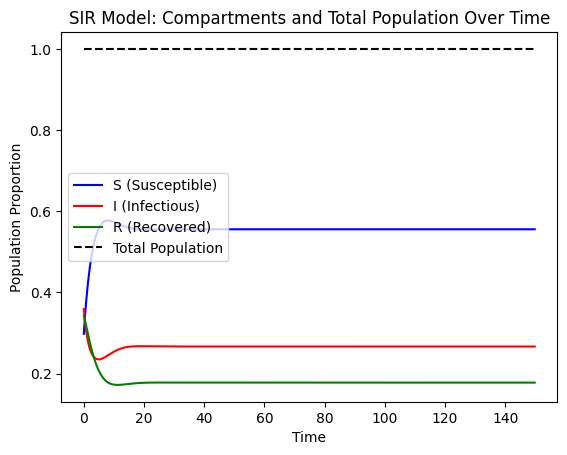

[0.29793006 0.32080618 0.34179292 0.36111726 0.37896176 0.39547566
 0.41078285 0.42498763 0.43817898 0.45043378 0.46181922 0.47239468
 0.48221312 0.49132225 0.4997654  0.50758221 0.51480922 0.52148031
 0.52762707 0.53327908 0.53846419 0.54320873 0.54753761 0.55147454
 0.55504211 0.55826186 0.56115442 0.56373952 0.56603609 0.56806226
 0.56983545 0.57137237 0.57268904 0.57380086 0.57472256 0.57546828
 0.57605154 0.57648528 0.57678186 0.57695306 0.57701011 0.57696368
 0.57682389 0.57660036 0.57630214 0.57593779 0.57551538 0.57504245
 0.57452609 0.5739729  0.57338905 0.57278023 0.57215174 0.57150843
 0.5708548  0.57019491 0.56953251 0.56887096 0.5682133  0.56756227
 0.56692029 0.5662895  0.56567179 0.56506879 0.56448188 0.56391227
 0.56336091 0.56282861 0.56231599 0.5618235  0.56135147 0.56090007
 0.56046938 0.56005935 0.55966984 0.55930064 0.55895143 0.55862185
 0.55831148 0.55801984 0.55774641 0.55749063 0.55725192 0.55702969
 0.55682329 0.5566321  0.55645546 0.55629273 0.55614326 0.5560

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Load the saved training or testing data (example: loading training data)
data = np.load('sir_training_data.npz')['data']  # You can load 'seird_testing_data.npz' similarly

# Time grid (ensure this matches the one used during data generation)
t = np.arange(0, 50, 0.2)

# Select the simulation you want to plot (e.g., the first simulation, index 0)
simulation_index = 41
S = data[simulation_index, :, 0]  # Susceptible
I = data[simulation_index, :, 1]  # Infectious
R = data[simulation_index, :, 2]  # Recovered

# Calculate the total population at each time step
total_population = S + I + R

# Plot each compartment
plt.plot(t, S, label='S (Susceptible)', color='blue')
plt.plot(t, I, label='I (Infectious)', color='red')
plt.plot(t, R, label='R (Recovered)', color='green')

# Plot the total population (should be constant if N=1)
plt.plot(t, total_population, label='Total Population', color='black', linestyle='--')

# Labels and title
plt.xlabel('Time')
plt.ylabel('Population Proportion')
plt.title('SIR Model: Compartments and Total Population Over Time')
plt.legend(loc='best')

# Show the plot
plt.show()
print(S)